## Import

In [1]:
import numpy as np
import cv2
from tqdm import trange
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(); sns.set_style('dark')
from ipywidgets import interact, interactive, fixed, interact_manual

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression



## Functions

In [2]:

def rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def bgr(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

def gray(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def uint8ify(img):
    img -= img.min()
    img /= img.max()
    img *= 255
    return np.uint8(img)

def overlay(a,b):
    # a and b should be float images and between 0-1

    mask = a >= 0.5 # generate boolean mask of everywhere a > 0.5 
    ab = np.zeros_like(a) # generate an output container for the blended image 

    # now do the blending 
    ab[~mask] = (2*a*b)[~mask] # 2ab everywhere a<0.5
    ab[mask] = (1-2*(1-a)*(1-b))[mask] # else this
    
    return ab

def disp(img, title='', s=8, vmin=None, vmax=None, write=False, file_name=None):
    plt.figure(figsize=(s,s))
    plt.axis('off')
    if vmin is not None and vmax is not None:
        plt.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
    else:
        plt.imshow(img, cmap='gray')
    plt.title(title)
    if write and file_name is not None:
        plt.savefig(file_name)
    plt.show()
    
def before_after(img_a, img_b, name="", vmin=None, vmax=None, effect_name="Processed"):
    fig, axs = plt.subplots(1,2, constrained_layout=True, figsize=(10,4))
    axs[0].axis('off')
    axs[1].axis('off')
    axs[0].set_title(f"{name} Original")
    axs[1].set_title(f"{name} {effect_name}")
    if vmin is not None and vmax is not None:
        axs[0].imshow(img_a, cmap='gray', vmin=vmin, vmax=vmax)
        axs[1].imshow(img_b, cmap='gray', vmin=vmin, vmax=vmax)
    else:
        axs[0].imshow(img_a, cmap='gray')
        axs[1].imshow(img_b, cmap='gray')
    plt.show()


## Loading Images

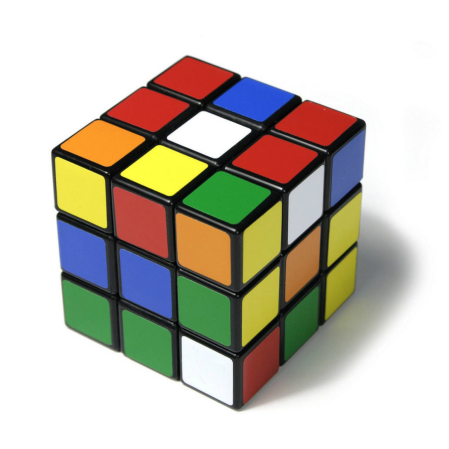

In [53]:
img_1 = rgb(cv2.imread("rubiks1_nologo.jpg"))
img_2 = rgb(cv2.imread("rubiks2.png"))
img_3 = rgb(cv2.imread("rubiks3.jpg"))
img_4 = rgb(cv2.imread("rubiks4.jpg"))
img_5 = rgb(cv2.imread("rubiks5.jpg"))

img_1_gray = cv2.imread("rubiks1_nologo.jpg", 0)
img_2_gray = cv2.imread("rubiks2.png", 0)
img_3_gray = cv2.imread("rubiks3.jpg", 0)
img_4_gray = cv2.imread("rubiks4.jpg", 0)
img_5_gray = cv2.imread("rubiks5.jpg", 0)

disp(img_1)

## Find Lines

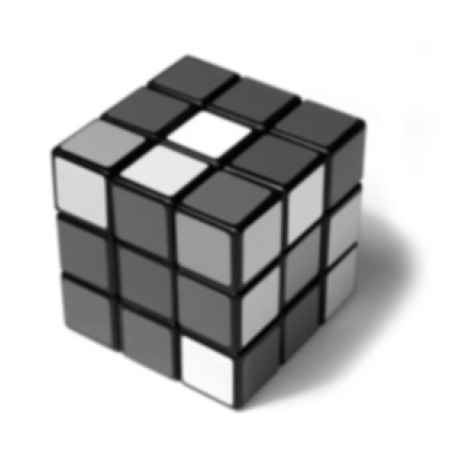

In [4]:
kernel_size = 5
blur_gray = cv2.GaussianBlur(img_1_gray,(kernel_size, kernel_size),0)
disp(blur_gray)

In [5]:
@interact(low_threshold=(0, 200, 1), high_threshold=(0, 200, 1))
def f(low_threshold = 160, high_threshold = 180):
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
    disp(edges)

interactive(children=(IntSlider(value=160, description='low_threshold', max=200), IntSlider(value=180, descrip…

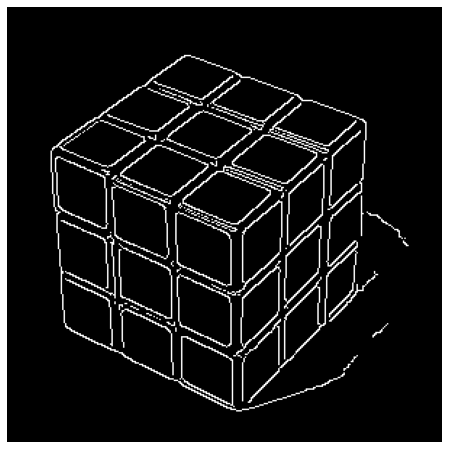

In [6]:
edges = cv2.Canny(blur_gray, 0, 75)
disp(edges)

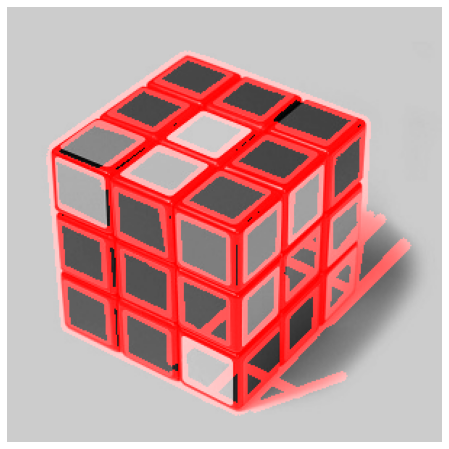

In [7]:
rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 15  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 40  # minimum number of pixels making up a line
max_line_gap = 20  # maximum gap in pixels between connectable line segments
line_image = np.copy(img_1) * 0  # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)

angles = []
for line in lines:
    for x1,y1,x2,y2 in line:
        angle = cv2.fastAtan2(float(y2-y1), float(x2-x1))
        angles.append(angle)
        # print(angle)
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),5)

# Draw the lines on the  image
img_1_gray_rgb = np.repeat(img_1_gray[:,:,None], 3, 2)
lines_edges = cv2.addWeighted(img_1_gray_rgb, 0.8, line_image, 1, 0)

disp(lines_edges)

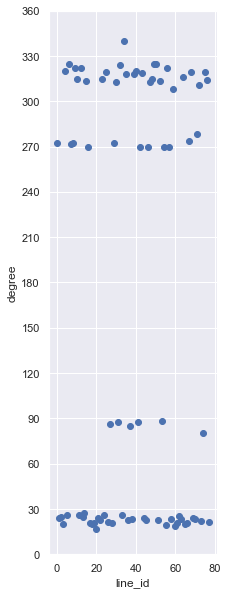

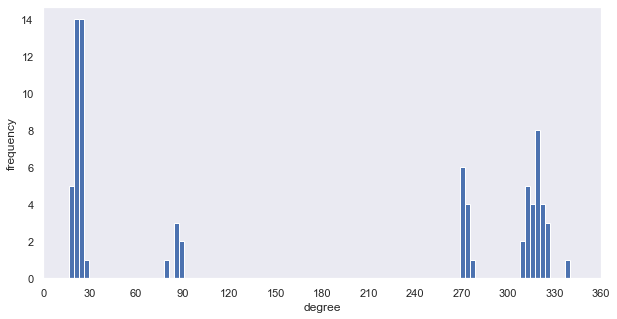

In [8]:
angles = np.array(angles)
plt.figure(figsize=(3,10))
plt.scatter(np.arange(len(angles)), angles)
plt.yticks(np.arange(0, 361, step=30))
plt.grid(True)
plt.ylabel("degree")
plt.xlabel("line_id")
plt.show()

plt.figure(figsize=(10,5))
plt.hist(angles.ravel(), bins=100)
plt.xticks(np.arange(0, 361, step=30))
plt.ylabel("frequency")
plt.xlabel("degree")
plt.show()

In [9]:
colors = [
    (245, 0, 87), #rgb(245, 0, 87)
    (0, 230, 118), #rgb(0, 230, 118)
    (25, 118, 210), #rgb(25, 118, 210)
    (245, 124, 0), #rgb(245, 124, 0)
    (124, 77, 255) #rgb(124, 77, 255)
]

colors_01 = [
    (245/255, 0/255, 87/255), #rgb(245, 0, 87)
    (0/255, 230/255, 118/255), #rgb(0, 230, 118)
    (25/255, 118/255, 210/255), #rgb(25, 118, 210)
    (245/255, 124/255, 0/255), #rgb(245, 124, 0)
    (124/255, 77/255, 255/255) #rgb(124, 77, 255)
]

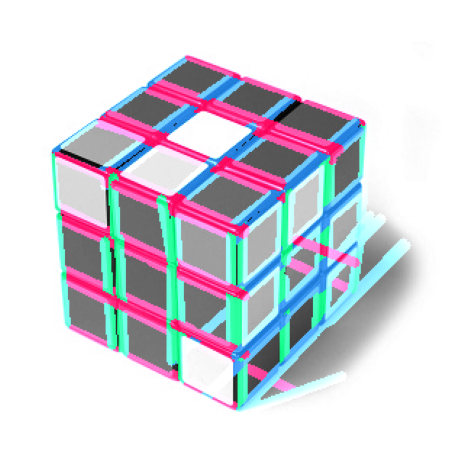

In [10]:
rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 15  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 40  # minimum number of pixels making up a line
max_line_gap = 20  # maximum gap in pixels between connectable line segments
line_image = np.copy(img_1) * 0  # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)

angles = []
vertical_lines = []
negative_lines = []
positive_lines = []
for idx, line in enumerate(lines):
    for x1,y1,x2,y2 in line:
        angle = cv2.fastAtan2(float(y2-y1), float(x2-x1))
        if angle>=180:
            angle -= 180
        angles.append(angle)

        if 0<=angle<=60:
            cluster_id = 0
            positive_lines.append([x1,y1,x2,y2])
        if 60<=angle<=120:
            cluster_id = 1
            vertical_lines.append([x1,y1,x2,y2])
        if 120<=angle<=180:
            cluster_id = 2
            negative_lines.append([x1,y1,x2,y2])
            
        cv2.line(line_image,(x1,y1),(x2,y2),colors[cluster_id],5)

# Draw the lines on the  image
img_1_gray_rgb = np.repeat(img_1_gray[:,:,None], 3, 2)
lines_edges = cv2.addWeighted(img_1_gray_rgb, 1, line_image, 1, 0)

disp(lines_edges)

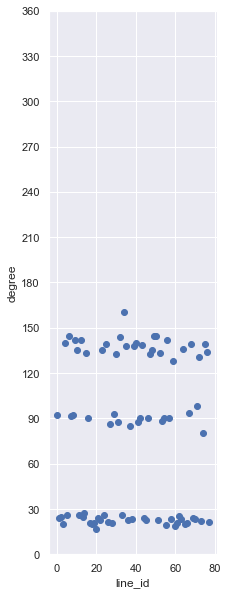

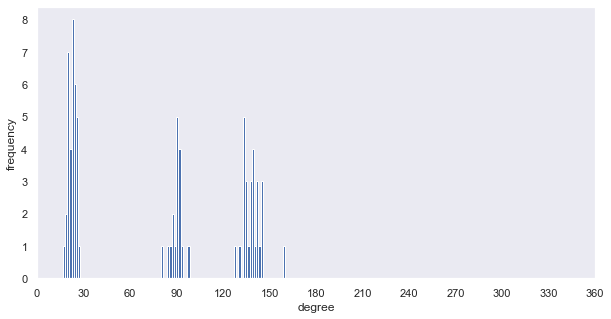

In [11]:
angles = np.array(angles)
plt.figure(figsize=(3,10))
plt.scatter(np.arange(len(angles)), angles)
plt.yticks(np.arange(0, 361, step=30))
plt.grid(True)
plt.ylabel("degree")
plt.xlabel("line_id")
plt.show()

plt.figure(figsize=(10,5))
plt.hist(angles.ravel(), bins=100)
plt.xticks(np.arange(0, 361, step=30))
plt.ylabel("frequency")
plt.xlabel("degree")
plt.show()

## Line types

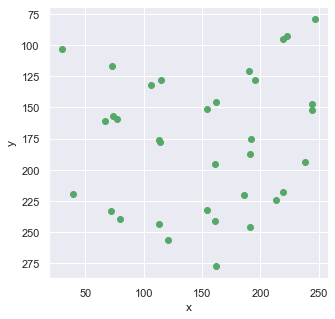

In [12]:
# vertical lines
points1 = np.zeros((len(vertical_lines)*2, 2))
for i in range(len(vertical_lines)):
    # point A on a line
    points1[2*i][0] = (vertical_lines[i][0])
    points1[2*i][1] = (vertical_lines[i][1])
    # point B on a line
    points1[2*i+1][0] = (vertical_lines[i][2])
    points1[2*i+1][1] = (vertical_lines[i][3])

    
plt.figure(figsize=(5,5))
plt.scatter(points1[:,0], points1[:,1], c='g')
plt.grid(True)
plt.gca().invert_yaxis()
plt.ylabel("y")
plt.xlabel("x")
plt.show()

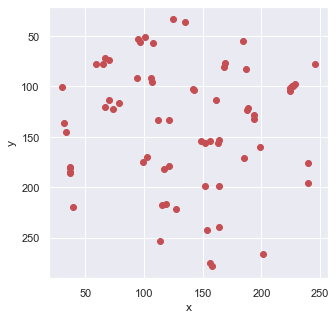

In [13]:
# positive lines
points2 = np.zeros((len(positive_lines)*2, 2))
for i in range(len(positive_lines)):
    # point A on a line
    points2[2*i][0] = (positive_lines[i][0])
    points2[2*i][1] = (positive_lines[i][1])
    # point B on a line
    points2[2*i+1][0] = (positive_lines[i][2])
    points2[2*i+1][1] = (positive_lines[i][3])
    
plt.figure(figsize=(5,5))
plt.scatter(points2[:,0], points2[:,1], c='r')
plt.grid(True)
plt.gca().invert_yaxis()
plt.ylabel("y")
plt.xlabel("x")
plt.show()

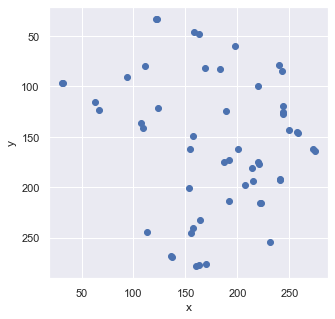

In [14]:
# vertical lines
points3 = np.zeros((len(negative_lines)*2, 2))
for i in range(len(negative_lines)):
    # point A on a line
    points3[2*i][0] = (negative_lines[i][0])
    points3[2*i][1] = (negative_lines[i][1])
    # point B on a line
    points3[2*i+1][0] = (negative_lines[i][2])
    points3[2*i+1][1] = (negative_lines[i][3])
    
plt.figure(figsize=(5,5))
plt.scatter(points3[:,0], points3[:,1])
plt.grid(True)
plt.gca().invert_yaxis()
plt.ylabel("y")
plt.xlabel("x")
plt.show()

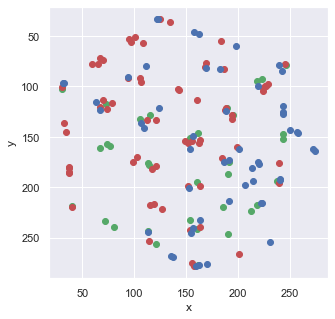

In [15]:
plt.figure(figsize=(5,5))
plt.scatter(points1[:,0], points1[:,1],c='g')
plt.scatter(points2[:,0], points2[:,1],c='r')
plt.scatter(points3[:,0], points3[:,1],c='b')
plt.grid(True)
plt.gca().invert_yaxis()
plt.ylabel("y")
plt.xlabel("x")
plt.show()

## Clustering

### Vertical Lines

Default clustering result: Bad

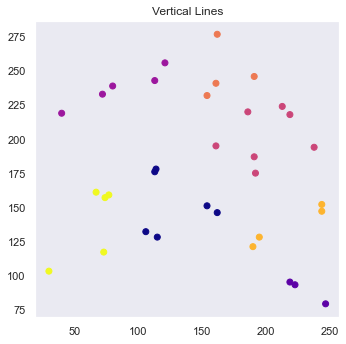

In [16]:
X = points1.copy()

y_pred_vertical_lines = KMeans(n_clusters=7, random_state=1).fit_predict(X)

plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1], c=y_pred_vertical_lines, cmap='plasma_r')
plt.title("Vertical Lines")
plt.show()

Divide the y component of the points by 10: Good

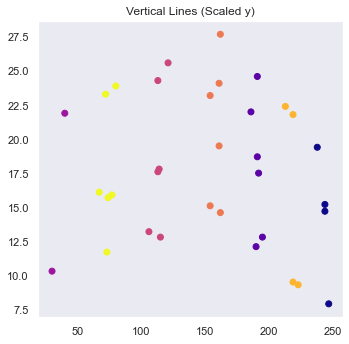

In [17]:
X = points1.copy()
X[:,1] /= 10

y_pred_vertical_lines = KMeans(n_clusters=7, random_state=1).fit_predict(X)

plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1], c=y_pred_vertical_lines, cmap='plasma_r')
plt.title("Vertical Lines (Scaled y)")
plt.show()

### Positive Lines

Default clustering result: Bad

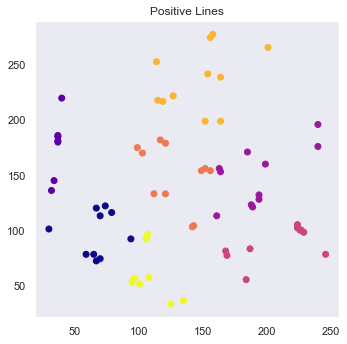

In [18]:
X = points2.copy()

y_pred_positive_lines = KMeans(n_clusters=7, random_state=1).fit_predict(X)

plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1], c=y_pred_positive_lines, cmap='plasma_r')
plt.title("Positive Lines")
plt.show()

Rotate the points by -60: Now they're like vertical lines

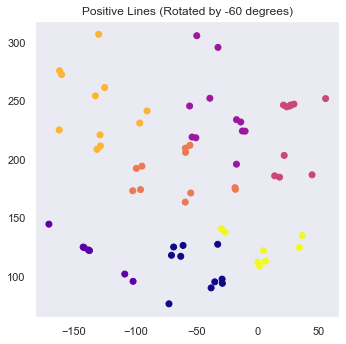

In [19]:
X = points2.copy()

# Let's Rotate the points by -60 degrees
theta = -60*np.pi/180

# Define the rotation matrix
R = np.array([
    [np.cos(theta), np.sin(theta)],
    [-np.sin(theta), np.cos(theta)]])
    
# Rotate the points
X_rotated = X @ R.T

y_pred_positive_lines = KMeans(n_clusters=7, random_state=1).fit_predict(X_rotated)

plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.scatter(X_rotated[:, 0], X_rotated[:, 1], c=y_pred_positive_lines, cmap='plasma_r')
plt.title("Positive Lines (Rotated by -60 degrees)")
plt.show()

Divide the y component of the points by 10: Good

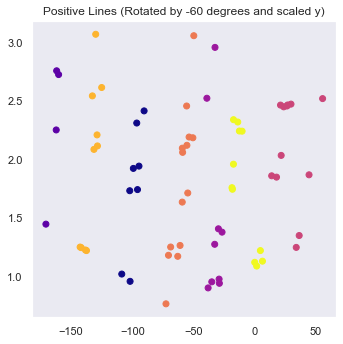

In [20]:
X = points2.copy()

# Let's Rotate the points by 60 degrees
theta = -60*np.pi/180

# Define the rotation matrix
R = np.array([
    [np.cos(theta), np.sin(theta)],
    [-np.sin(theta), np.cos(theta)]])

# Rotate the points
X_rotated = X @ R.T

X_rotated[:,1] /= 100

y_pred_positive_lines = KMeans(n_clusters=7, random_state=1).fit_predict(X_rotated)

plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.scatter(X_rotated[:, 0], X_rotated[:, 1], c=y_pred_positive_lines, cmap='plasma_r')
plt.title("Positive Lines (Rotated by -60 degrees and scaled y)")
plt.show()

### Negative Lines

Default clustering result: Bad

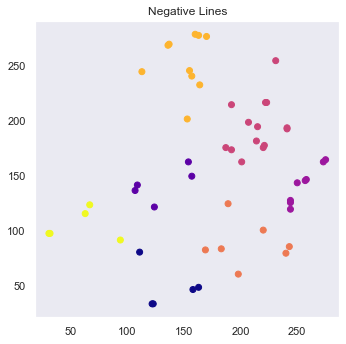

In [21]:
X = points3.copy()

y_pred_negative_lines = KMeans(n_clusters=7, random_state=1).fit_predict(X)

plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1], c=y_pred_negative_lines, cmap='plasma_r')
plt.title("Negative Lines")
plt.show()

Rotate the points by +60: Now they're like vertical lines

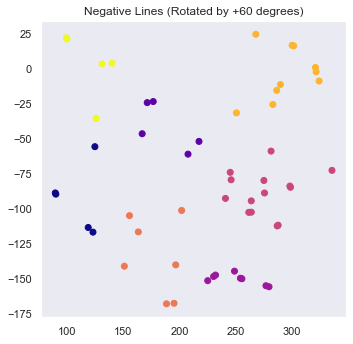

In [22]:
X = points3.copy()

# Let's Rotate the points by -60 degrees
theta = 60*np.pi/180

# Define the rotation matrix
R = np.array([
    [np.cos(theta), np.sin(theta)],
    [-np.sin(theta), np.cos(theta)]])
    
# Rotate the points
X_rotated = X @ R.T

y_pred_negative_lines = KMeans(n_clusters=7, random_state=1).fit_predict(X_rotated)

plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.scatter(X_rotated[:, 0], X_rotated[:, 1], c=y_pred_negative_lines, cmap='plasma_r')
plt.title("Negative Lines (Rotated by +60 degrees)")
plt.show()

Divide the y component of the points by 10: Good

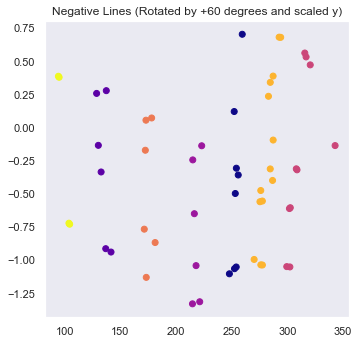

In [23]:
X = points3.copy()

# Let's Rotate the points by 60 degrees
theta = 50*np.pi/180

# Define the rotation matrix
R = np.array([
    [np.cos(theta), np.sin(theta)],
    [-np.sin(theta), np.cos(theta)]])

# Rotate the points
X_rotated = X @ R.T

X_rotated[:,1] /= 100

y_pred_negative_lines = KMeans(n_clusters=7, random_state=1).fit_predict(X_rotated)

plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.scatter(X_rotated[:, 0], X_rotated[:, 1], c=y_pred_negative_lines, cmap='plasma_r')
plt.title("Negative Lines (Rotated by +60 degrees and scaled y)")
plt.show()

## Line Fitting

### Vertical Lines

Coefficients: 
 0.08620689655172413
Intercept: 
 21.120689655172413


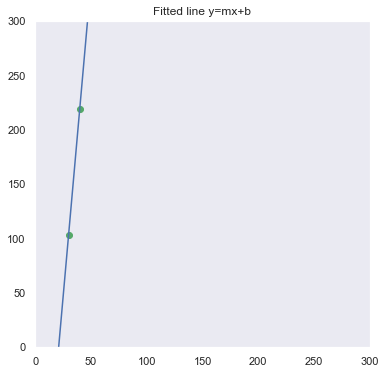

In [24]:
# Select only one cluster
cluster_id =4
X = points1.copy()[y_pred_vertical_lines==cluster_id]

# Create linear regression object
regr = LinearRegression()

# Train the model using the training sets
regr.fit(X[:,1].reshape(-1, 1), X[:,0])

# The coefficients
print("Coefficients: \n", regr.coef_[0])
print("Intercept: \n", regr.intercept_)

m = regr.coef_[0]
b = regr.intercept_

x = np.arange(0,img_1.shape[1])
y = m*x+b

plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c='g', cmap='plasma_r')
plt.plot(y, x)
plt.ylim([0,img_1.shape[0]])
plt.xlim([0,img_1.shape[1]])
plt.title("Fitted line y=mx+b")

plt.show()


In [25]:
fitted_ms_all = []
fitted_bs_all = []
scalers_all = []

In [26]:
fitted_ms = []
fitted_bs = []
scalers = []

# vertical lines
for cluster_id in range(7):
    X = points1.copy()[y_pred_vertical_lines==cluster_id]
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    scalers.append(scaler)

    regr = LinearRegression()
    regr.fit(X[:,1].reshape(-1, 1), X[:,0])

    m = regr.coef_[0]
    b = regr.intercept_

    fitted_ms.append(m)
    fitted_bs.append(b)

fitted_ms_all.append(fitted_ms)
fitted_bs_all.append(fitted_bs)
scalers_all.append(scalers)

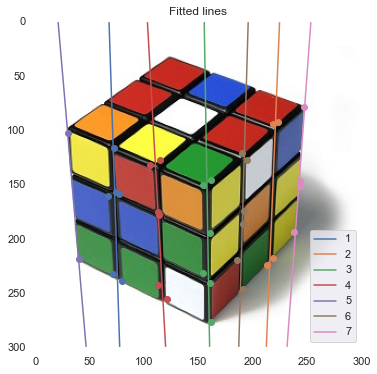

In [27]:
plt.figure(figsize=(6, 6))
plt.imshow(img_1)
for cluster_id in range(7):
    # Get the points of this cluster
    X = points1.copy()[y_pred_vertical_lines==cluster_id]
    
    # Get the corresponding scaler
    scaler = scalers[cluster_id]

    # Calculate the points in the current line
    x = np.arange(0,img_1.shape[1])
    # Scale the x values so that they work with m and b
    x = scaler.transform(np.repeat(x[:,None], 2, axis=1))[:,0]
    y = fitted_ms[cluster_id]*x+fitted_bs[cluster_id]

    # Concatenate fitted line's x and y
    line_X = np.column_stack([y, x])
    
    # Inverse Scaler transform
    line_X = scaler.inverse_transform(line_X)

    plt.scatter(X[:, 0], X[:, 1], cmap='plasma_r')
    plt.plot(line_X[:, 0], line_X[:, 1])

plt.ylim([0,img_1.shape[0]])
plt.xlim([0,img_1.shape[1]])
plt.gca().invert_yaxis()
plt.legend([1,2,3,4,5,6,7])
plt.title("Fitted lines")

plt.show()


### Positive Lines

In [28]:
fitted_ms = []
fitted_bs = []
scalers = []

# Positive lines
for cluster_id in range(7):
    X = points2.copy()[y_pred_positive_lines==cluster_id]
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    scalers.append(scaler)

    regr = LinearRegression()
    regr.fit(X[:,0].reshape(-1, 1), X[:,1])

    m = regr.coef_[0]
    b = regr.intercept_

    fitted_ms.append(m)
    fitted_bs.append(b)

fitted_ms_all.append(fitted_ms)
fitted_bs_all.append(fitted_bs)
scalers_all.append(scalers)

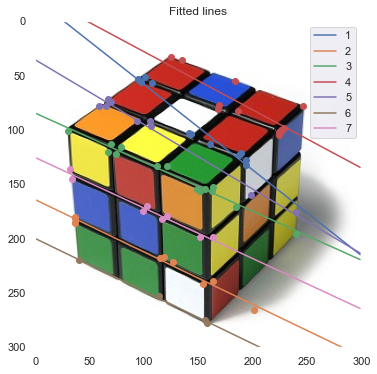

In [29]:
plt.figure(figsize=(6, 6))
plt.imshow(img_1)
for cluster_id in range(7):
    # Get the points of this cluster
    X = points2.copy()[y_pred_positive_lines==cluster_id]
    
    # Get the corresponding scaler
    scaler = scalers[cluster_id]

    # Calculate the points in the current line
    x = np.arange(0,img_1.shape[1])
    # Scale the x values so that they work with m and b
    x = scaler.transform(np.repeat(x[:,None], 2, axis=1))[:,0]
    y = fitted_ms[cluster_id]*x+fitted_bs[cluster_id]

    # Concatenate fitted line's x and y
    line_X = np.column_stack([x,y])
    
    # Inverse Scaler transform
    line_X = scaler.inverse_transform(line_X)

    plt.scatter(X[:, 0], X[:, 1], cmap='plasma_r')
    plt.plot(line_X[:, 0], line_X[:, 1])

plt.ylim([0,img_1.shape[0]])
plt.xlim([0,img_1.shape[1]])
plt.gca().invert_yaxis()
plt.legend([1,2,3,4,5,6,7])
plt.title("Fitted lines")

plt.show()


### Negative Lines

In [30]:
fitted_ms = []
fitted_bs = []
scalers = []

# Negative lines
for cluster_id in range(7):
    X = points3.copy()[y_pred_negative_lines==cluster_id]
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    scalers.append(scaler)

    regr = LinearRegression()
    regr.fit(X[:,0].reshape(-1, 1), X[:,1])

    m = regr.coef_[0]
    b = regr.intercept_

    fitted_ms.append(m)
    fitted_bs.append(b)

fitted_ms_all.append(fitted_ms)
fitted_bs_all.append(fitted_bs)
scalers_all.append(scalers)

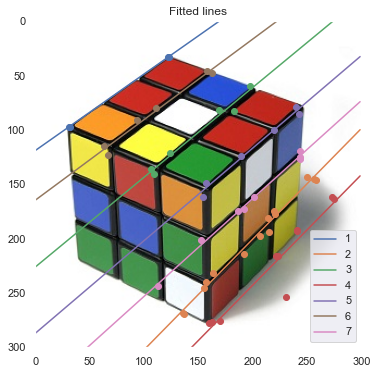

In [31]:
plt.figure(figsize=(6, 6))
plt.imshow(img_1)
for cluster_id in range(7):
    # Get the points of this cluster
    X = points3.copy()[y_pred_negative_lines==cluster_id]
    
    # Get the corresponding scaler
    scaler = scalers[cluster_id]

    # Calculate the points in the current line
    x = np.arange(0,img_1.shape[1])
    # Scale the x values so that they work with m and b
    x = scaler.transform(np.repeat(x[:,None], 2, axis=1))[:,0]
    y = fitted_ms[cluster_id]*x+fitted_bs[cluster_id]

    # Concatenate fitted line's x and y
    line_X = np.column_stack([x,y])
    
    # Inverse Scaler transform
    line_X = scaler.inverse_transform(line_X)

    plt.scatter(X[:, 0], X[:, 1], cmap='plasma_r')
    plt.plot(line_X[:, 0], line_X[:, 1])

plt.ylim([0,img_1.shape[0]])
plt.xlim([0,img_1.shape[1]])
plt.gca().invert_yaxis()
plt.legend([1,2,3,4,5,6,7])
plt.title("Fitted lines")

plt.show()


### All together

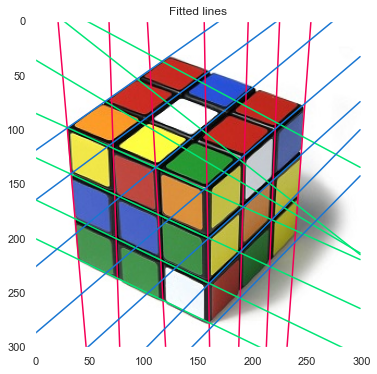

In [32]:
plt.figure(figsize=(6, 6))
plt.imshow(img_1)

for i in range(3):
    for cluster_id in range(7):
        # Get the points of this cluster
        if i==0:
            X = points1.copy()[y_pred_vertical_lines==cluster_id]
        elif i==1:
            X = points2.copy()[y_pred_positive_lines==cluster_id]
        elif i==2:
            X = points3.copy()[y_pred_negative_lines==cluster_id]
        
        # Get the corresponding scaler
        scaler = scalers_all[i][cluster_id]

        # Calculate the points in the current line
        x = np.arange(0,img_1.shape[1])

        # Scale the x values so that they work with m and b
        x = scaler.transform(np.repeat(x[:,None], 2, axis=1))[:,0]
        y = fitted_ms_all[i][cluster_id]*x+fitted_bs_all[i][cluster_id]

        # Concatenate fitted line's x and y
        if i==0:
            line_X = np.column_stack([y,x])
        else:
            line_X = np.column_stack([x,y])
        
        # Inverse Scaler transform
        line_X = scaler.inverse_transform(line_X)

        # plt.scatter(X[:, 0], X[:, 1], cmap='plasma_r')
        plt.plot(line_X[:, 0], line_X[:, 1], c=colors_01[i], linewidth=1.5)

plt.ylim([0,img_1.shape[0]])
plt.xlim([0,img_1.shape[1]])
plt.gca().invert_yaxis()
# plt.legend([1,2,3,4,5,6,7])
plt.title("Fitted lines")

plt.show()


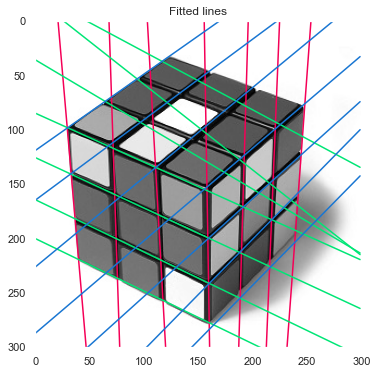

In [33]:
plt.figure(figsize=(6, 6))
plt.imshow(img_1_gray_rgb)

for i in range(3):
    for cluster_id in range(7):
        # Get the points of this cluster
        if i==0:
            X = points1.copy()[y_pred_vertical_lines==cluster_id]
        elif i==1:
            X = points2.copy()[y_pred_positive_lines==cluster_id]
        elif i==2:
            X = points3.copy()[y_pred_negative_lines==cluster_id]
        
        # Get the corresponding scaler
        scaler = scalers_all[i][cluster_id]

        # Calculate the points in the current line
        x = np.arange(0,img_1.shape[1])

        # Scale the x values so that they work with m and b
        x = scaler.transform(np.repeat(x[:,None], 2, axis=1))[:,0]
        y = fitted_ms_all[i][cluster_id]*x+fitted_bs_all[i][cluster_id]

        # Concatenate fitted line's x and y
        if i==0:
            line_X = np.column_stack([y,x])
        else:
            line_X = np.column_stack([x,y])
        
        # Inverse Scaler transform
        line_X = scaler.inverse_transform(line_X)

        # plt.scatter(X[:, 0], X[:, 1], cmap='plasma_r')
        plt.plot(line_X[:, 0], line_X[:, 1], c=colors_01[i], linewidth=1.5)

plt.ylim([0,img_1.shape[0]])
plt.xlim([0,img_1.shape[1]])
plt.gca().invert_yaxis()
# plt.legend([1,2,3,4,5,6,7])
plt.title("Fitted lines")

plt.show()


## End to End Function

In [34]:
import time
a = time.perf_counter_ns()
time.sleep(1)
b = time.perf_counter_ns()
print((b-a)/10**6, "ms")

1014.8807 ms


In [35]:
def line_to_points(lines):
    points = np.zeros((len(lines)*2, 2))
    for i in range(len(lines)):
        # point A on a line
        points[2*i][0] = (lines[i][0])
        points[2*i][1] = (lines[i][1])
        # point B on a line
        points[2*i+1][0] = (lines[i][2])
        points[2*i+1][1] = (lines[i][3])
    return points

## Clustering

In [36]:
def cluster_points(points, rotate_degree=0, squash_factor=100, n_clusters=7, debug=False):
    X = points.copy()

    if rotate_degree!=0:
        # Let's Rotate the points by 'rotate_degree' degrees
        theta = rotate_degree*np.pi/180

        # Define the rotation matrix
        R = np.array([
            [np.cos(theta), np.sin(theta)],
            [-np.sin(theta), np.cos(theta)]])

        # Rotate the points
        X = X @ R.T

    X[:,1] /= squash_factor

    cluster_ids = KMeans(n_clusters=n_clusters, random_state=1, algorithm='auto', max_iter=20, n_init=1).fit_predict(X)

    if debug:
        plt.figure(figsize=(6, 6))
        plt.scatter(X[:, 0], X[:, 1], c=cluster_ids, cmap='plasma_r')
        plt.title(f"Positive Lines (Rotated by {rotate_degree} degrees and scaled y by {squash_factor})")
        plt.show()

    return cluster_ids
    

In [37]:
class GHD_Scaler:
    def __init__(self):
        pass

    def fit(self, X):
        pass

    def transform(self, X):
        return X

    def inverse_transform(self, X):
        return X

In [38]:
def fit_lines(points, y_pred, n_clusters=7, is_vertical=False):
    fitted_ms = []
    fitted_bs = []
    scalers = []

    for cluster_id in range(n_clusters):
        X = points.copy()[y_pred==cluster_id]

        # Scale features
        scaler = GHD_Scaler()
        scaler.fit(X)
        X = scaler.transform(X)
        scalers.append(scaler)

        # Fit a line to the points using linear regression
        regr = LinearRegression()

        # If 'is_vertical': fit x=my+b instead of y=mx+b
        if is_vertical:
            regr.fit(X[:,1].reshape(-1, 1), X[:,0])
        else:
            regr.fit(X[:,0].reshape(-1, 1), X[:,1])

        m = regr.coef_[0]
        b = regr.intercept_

        fitted_ms.append(m)
        fitted_bs.append(b)
    
    return fitted_ms, fitted_bs, scalers


In [39]:
def extract_faces(img, kernel_size=5, canny_low=0, canny_high=75, min_line_length=40, max_line_gap=20, rotate_degrees=[0, -60, 50], colors=None, colors_01=None, n_clusters=7, debug=False, debug_time=True):
    """Takes an image of a rubiks cube, finds edges, fits lines to edges and extracts the faces

    Args:
        img (RGB image): rubiks cube image
    """
    start_time = time.perf_counter_ns()

    # 1. Convert to Gray
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    if debug_time:
        print("1. Convert to Gray:\t",(time.perf_counter_ns() - start_time)/1000000, "ms")
        start_time = time.perf_counter_ns()

    # 2. Blur
    blur_gray = cv2.GaussianBlur(img_gray,(kernel_size, kernel_size),0)

    if debug_time:
        print("2. Blur Gray:\t\t",(time.perf_counter_ns() - start_time)/1000000, "ms")
        start_time = time.perf_counter_ns()
    if debug:
        disp(blur_gray)

    # 3. Canny
    edges = cv2.Canny(blur_gray, canny_low, canny_high)
    if debug_time:
        print("3. Canny:\t\t",(time.perf_counter_ns() - start_time)/1000000, "ms")
        start_time = time.perf_counter_ns()
    if debug:
        disp(edges)

    # 4. HoughLinesP
    # Distance resolution in pixels of the Hough grid
    rho = 1
    # Angular resolution in radians of the Hough grid
    theta = np.pi / 180
    # Other Hough params
    threshold = 15
    min_line_length = min_line_length
    max_line_gap = max_line_gap
    line_image = np.copy(img) * 0

    # Run Hough on edge detected image
    lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                        min_line_length, max_line_gap)
    if debug_time:
        print("4. HoughLinesP:\t\t",(time.perf_counter_ns() - start_time)/1000000, "ms")
        start_time = time.perf_counter_ns()

    # 5. Calculate Angles
    angles = []
    vertical_lines = []
    negative_lines = []
    positive_lines = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            # Calculate the angle
            angle = cv2.fastAtan2(float(y2-y1), float(x2-x1))
            angles.append(angle)

            # 210 == 180+30 == 30
            if angle>=180:
                angle -= 180
            angles.append(angle)
            
            # Find the type of the line
            if 0<=angle<=60:
                cluster_id = 0
                positive_lines.append([x1,y1,x2,y2])
            if 60<=angle<=120:
                cluster_id = 1
                vertical_lines.append([x1,y1,x2,y2])
            if 120<=angle<=180:
                cluster_id = 2
                negative_lines.append([x1,y1,x2,y2])
                
            if debug:
                cv2.line(line_image,(x1,y1),(x2,y2),colors[cluster_id],5)
    
    if debug_time:
        print("5. Calc Angles:\t\t",(time.perf_counter_ns() - start_time)/1000000, "ms")
        start_time = time.perf_counter_ns()

    # Draw the lines on the  image
    if debug:
        img_gray_rgb = np.repeat(img_gray[:,:,None], 3, 2)
        lines_edges = cv2.addWeighted(img_gray_rgb, 0.8, line_image, 1, 0)
        disp(lines_edges)
    
    # 6. Lines to points
    points_1 = line_to_points(vertical_lines)
    points_2 = line_to_points(positive_lines)
    points_3 = line_to_points(negative_lines)

    if debug_time:
        print("6. Lines to Points:\t",(time.perf_counter_ns() - start_time)/1000000, "ms")
        start_time = time.perf_counter_ns()
    

    # 7. Cluster points
    y_pred_1 = cluster_points(points_1, rotate_degree=rotate_degrees[0], squash_factor=100, debug=debug)
    y_pred_2 = cluster_points(points_2, rotate_degree=rotate_degrees[1], squash_factor=100, debug=debug)
    y_pred_3 = cluster_points(points_3, rotate_degree=rotate_degrees[2], squash_factor=100, debug=debug)

    if debug_time:
        print("7. Clustering:\t\t",(time.perf_counter_ns() - start_time)/1000000, "ms")
        start_time = time.perf_counter_ns()


    # 8. Line Fitting (y=mx+b) or (x=my+b)
    fitted_ms_1, fitted_bs_1, scalers_1 = fit_lines(points_1, y_pred_1, n_clusters=n_clusters, is_vertical=True)
    fitted_ms_2, fitted_bs_2, scalers_2 = fit_lines(points_2, y_pred_2, n_clusters=n_clusters, is_vertical=False)
    fitted_ms_3, fitted_bs_3, scalers_3 = fit_lines(points_3, y_pred_3, n_clusters=n_clusters, is_vertical=False)

    fitted_ms_all = [fitted_ms_1, fitted_ms_2, fitted_ms_3]
    fitted_bs_all = [fitted_bs_1, fitted_bs_2, fitted_bs_3]
    scalers_all = [scalers_1, scalers_2, scalers_3]

    if debug_time:
        print("8. Line Fitting:\t",(time.perf_counter_ns() - start_time)/1000000, "ms")
        start_time = time.perf_counter_ns()

    # 9. Plot Lines on the cube
    if debug:
        plot_lines_on_cube(
            points_1, points_2, points_3, fitted_ms_all, fitted_bs_all, scalers_all,  img_gray_rgb, y_pred_1, y_pred_2, y_pred_3,
            direction_list=[0,1],
            n_clusters=n_clusters)
        
        plot_lines_on_cube(
            points_1, points_2, points_3, fitted_ms_all, fitted_bs_all, scalers_all,  img_gray_rgb, y_pred_1, y_pred_2, y_pred_3,
            direction_list=[0,2],
            n_clusters=n_clusters)
        
        plot_lines_on_cube(
            points_1, points_2, points_3, fitted_ms_all, fitted_bs_all, scalers_all,  img_gray_rgb, y_pred_1, y_pred_2, y_pred_3,
            direction_list=[1,2],
            n_clusters=n_clusters)
    if debug_time:
        print("9. Plot Lines:\t\t",(time.perf_counter_ns() - start_time)/1000000, "ms")
        start_time = time.perf_counter_ns()
    
    # 10. Find intersection points
    
    img_gray_rgb = np.repeat(img_gray[:,:,None], 3, 2)
    points_on_left_face = plot_intersection_points_on_cube(
        fitted_ms_all, fitted_bs_all, scalers_all,  img_gray_rgb,
        direction_list=[0,1], debug=debug)
    
    points_on_right_face = plot_intersection_points_on_cube(
        fitted_ms_all, fitted_bs_all, scalers_all,  img_gray_rgb,
        direction_list=[0,2], debug=debug)
    
    points_on_top_face = plot_intersection_points_on_cube(
        fitted_ms_all, fitted_bs_all, scalers_all,  img_gray_rgb,
        direction_list=[1,2], debug=debug)

    if debug_time:
        print("10. Find Intersections:\t",(time.perf_counter_ns() - start_time)/1000000, "ms")
        start_time = time.perf_counter_ns()
        
    # 11. Find face centers
    points_left = np.array(points_on_left_face)
    points_right = np.array(points_on_right_face)
    points_top = np.array(points_on_top_face)

    face_indices = [
        [2,3,7,6],[6,7,11,10],[10,11,15,14],
        [1,2,6,5],[5,6,10,9],[9,10,14,13],
        [0,1,5,4],[4,5,9,8],[8,9,13,12]
        ]

    face_centers = [[],[],[]]
    if debug:
        plt.imshow(img_gray_rgb)
    for face in face_indices:
        face_center = (points_left[face[0]] + points_left[face[1]] + points_left[face[2]] + points_left[face[3]]) / 4
        face_centers[0].append(face_center)
        if debug:
            plt.scatter([face_center[0]],[face_center[1]], c='r')

    for face in face_indices:
        face_center = (points_right[face[0]] + points_right[face[1]] + points_right[face[2]] + points_right[face[3]]) / 4
        face_centers[1].append(face_center)
        if debug:
            plt.scatter([face_center[0]],[face_center[1]], c='g')

    for face in face_indices:
        face_center = (points_top[face[0]] + points_top[face[1]] + points_top[face[2]] + points_top[face[3]]) / 4
        face_centers[2].append(face_center)
        if debug:
            plt.scatter([face_center[0]],[face_center[1]], c='b')

    if debug_time:
        print("11. Extract Face Centers:",(time.perf_counter_ns() - start_time)/1000000, "ms")
        start_time = time.perf_counter_ns()

    # 12. Extract face colors

    reconstructed_faces = []
    faces_names = ["Left", "Right", "Top"]
    if debug:
        disp(img)
    for f in range(3):
        reconstructed_face = np.zeros((3,3,3), dtype=np.uint8)
        for i in range(9):
                x,y = face_centers[f][i]
                x,y = int(x), int(y)
                w = 10
                mean_color = img[y-w//2:y+w//2, x-w//2:x+w//2].mean(axis=(0,1)).astype(np.uint8)
                reconstructed_face[i//3,i%3,:] = mean_color

        if debug:
            disp(reconstructed_face, s=3, title=faces_names[f])
        
        reconstructed_faces.append(reconstructed_face)

    if debug_time:
        print("12. Extract Face Colors:",(time.perf_counter_ns() - start_time)/1000000, "ms")
        start_time = time.perf_counter_ns()
    
    
    
    return fitted_ms_all, fitted_bs_all, scalers_all, points_on_left_face, points_on_right_face, points_on_top_face, reconstructed_faces

In [40]:
def plot_intersection_points_on_cube(fitted_ms_all, fitted_bs_all, scalers_all,  img_gray_rgb, direction_list=[1,2], debug=True, c="g"):
    points_on_the_face = []

    if debug:
        plt.figure(figsize=(6, 6))
        plt.imshow(img_gray_rgb)

    # Sort lines from left to right and bottom to top
    msi = fitted_ms_all[direction_list[0]]
    bsi = fitted_bs_all[direction_list[0]]
    scaler_i = scalers_all[direction_list[0]]

    # Sort lines by b
    if direction_list[0] == 0 and direction_list[1] == 2:
        sorted_indices_i = np.argsort(bsi)[::-1]
    elif direction_list[0] == 0 and direction_list[1] == 1:
        sorted_indices_i = np.argsort(bsi)
    else:
        sorted_indices_i = np.argsort(bsi)

    msi = np.array(msi)[sorted_indices_i]
    bsi = np.array(bsi)[sorted_indices_i]
    scaler_i = np.array(scaler_i)[sorted_indices_i]
    
    msj = fitted_ms_all[direction_list[1]]
    bsj = fitted_bs_all[direction_list[1]]
    scaler_j= scalers_all[direction_list[1]]

    # sort lines by b
    if direction_list[0] == 0 and direction_list[1] == 2:
        sorted_indices_j = np.argsort(bsj)[::-1]
    elif direction_list[0] == 0 and direction_list[1] == 1:
        sorted_indices_j = np.argsort(bsj)[::-1]
    else:
        sorted_indices_j = np.argsort(bsj)

    msj = np.array(msj)[sorted_indices_j]
    bsj = np.array(bsj)[sorted_indices_j]
    scaler_j = np.array(scaler_j)[sorted_indices_j]


    # first 4 lines of dir_a
    for i in range(4):
        # first 4 lines of dir_b
        for j in range(4):
            m1 = msi[i]
            b1 = bsi[i]
            m2 = msj[j]
            b2 = bsj[j]
            if direction_list[0] == 0:
                b1 = -b1/m1
                m1 = 1/m1
            
            x = (b2-b1)/(m1-m2)
            y = m1*x+b1

            points_on_the_face.append([x,y])

            if debug:
                plt.scatter([x], [y], c=c)

    if debug:
        plt.ylim([0,img_gray_rgb.shape[0]])
        plt.xlim([0,img_gray_rgb.shape[1]])
        plt.gca().invert_yaxis()
        plt.title("Fitted lines")

        plt.show()

    return points_on_the_face

In [41]:
def plot_lines_on_cube(points_1, points_2, points_3, fitted_ms_all, fitted_bs_all, scalers_all,  img_gray_rgb, y_pred_1, y_pred_2, y_pred_3, direction_list=[0,1,2], n_clusters=7):
    plt.figure(figsize=(6, 6))
    plt.imshow(img_gray_rgb)

    for i in direction_list:
        for cluster_id in range(n_clusters):
            # Get the points of this cluster
            if i==0:
                X = points_1.copy()[y_pred_1==cluster_id]
            elif i==1:
                X = points_2.copy()[y_pred_2==cluster_id]
            elif i==2:
                X = points_3.copy()[y_pred_3==cluster_id]
            
            # Get the corresponding scaler
            scaler = scalers_all[i][cluster_id]

            # Calculate the points in the current line
            x = np.arange(0,img_gray_rgb.shape[1])

            # Scale the x values so that they work with m and b
            x = scaler.transform(np.repeat(x[:,None], 2, axis=1))[:,0]
            y = fitted_ms_all[i][cluster_id]*x+fitted_bs_all[i][cluster_id]

            # Concatenate fitted line's x and y
            if i==0:
                # if vertical: x=my+b
                line_X = np.column_stack([y,x])
            else:
                # else: y=mx+b
                line_X = np.column_stack([x,y])
            
            # Inverse Scaler transform
            line_X = scaler.inverse_transform(line_X)

            plt.plot(line_X[:, 0], line_X[:, 1], c=colors_01[i], linewidth=1.5)

    plt.ylim([0,img_gray_rgb.shape[0]])
    plt.xlim([0,img_gray_rgb.shape[1]])
    plt.gca().invert_yaxis()
    plt.title("Fitted lines")

    plt.show()

## Main

In [42]:
colors = [
    (245, 0, 87), #rgb(245, 0, 87)
    (0, 230, 118), #rgb(0, 230, 118)
    (25, 118, 210), #rgb(25, 118, 210)
    (245, 124, 0), #rgb(245, 124, 0)
    (124, 77, 255) #rgb(124, 77, 255)
]

colors_01 = [
    (245/255, 0/255, 87/255), #rgb(245, 0, 87)
    (0/255, 230/255, 118/255), #rgb(0, 230, 118)
    (25/255, 118/255, 210/255), #rgb(25, 118, 210)
    (245/255, 124/255, 0/255), #rgb(245, 124, 0)
    (124/255, 77/255, 255/255) #rgb(124, 77, 255)
]

1. Convert to Gray:	 0.5492 ms
2. Blur Gray:		 0.6666 ms


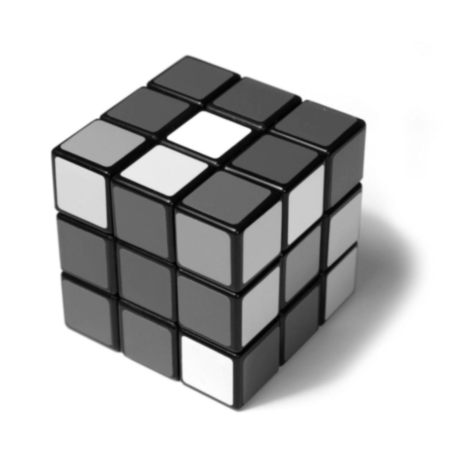

3. Canny:		 228.5141 ms


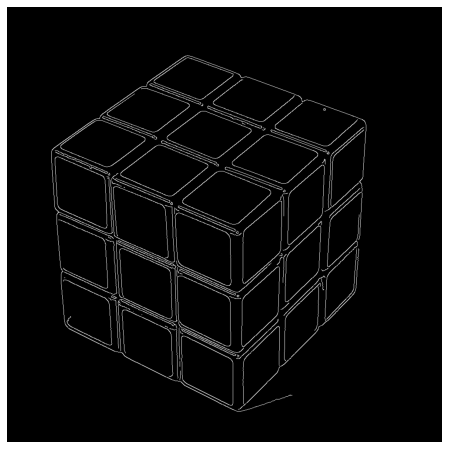

4. HoughLinesP:		 225.8112 ms
5. Calc Angles:		 4.2159 ms


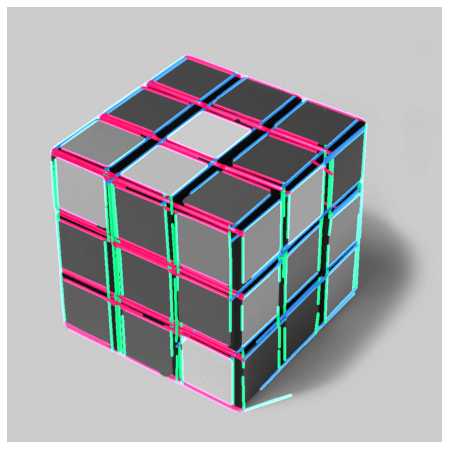

6. Lines to Points:	 355.0187 ms


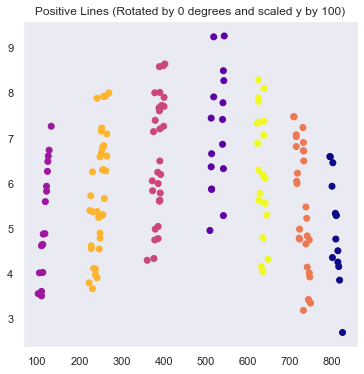

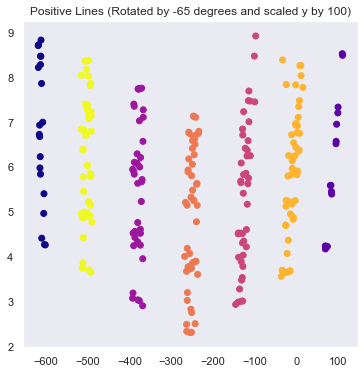

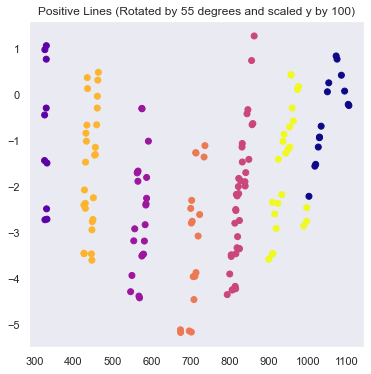

7. Clustering:		 615.6028 ms
8. Line Fitting:	 9.8823 ms


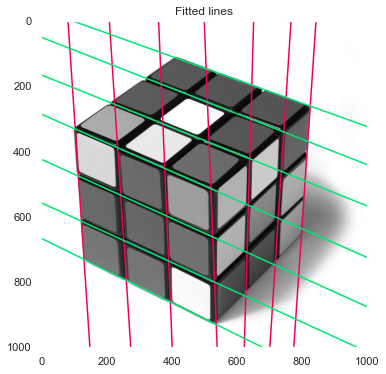

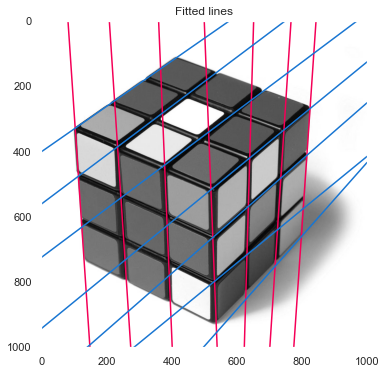

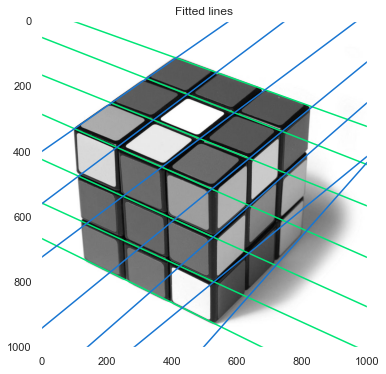

9. Plot Lines:		 964.025 ms


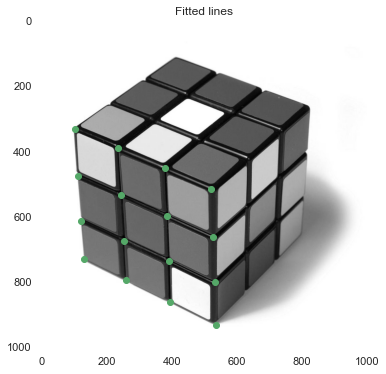

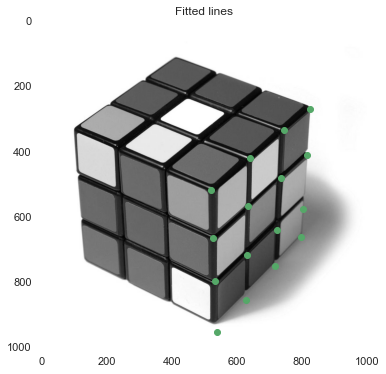

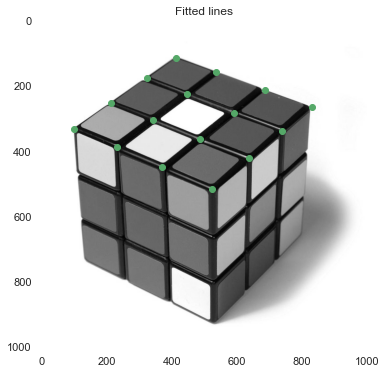

10. Find Intersections:	 1455.6444 ms
11. Extract Face Centers: 89.6417 ms


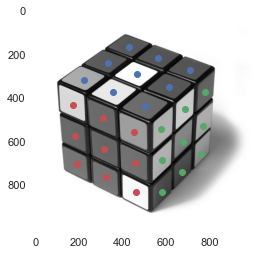

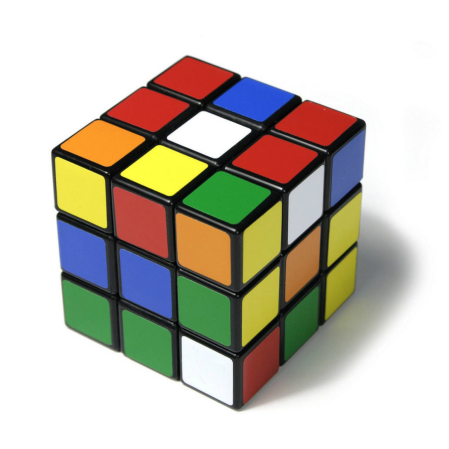

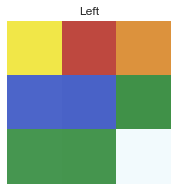

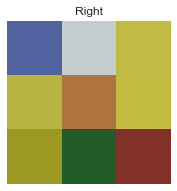

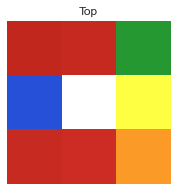

12. Extract Face Colors: 1116.1578 ms
CPU times: total: 5.28 s
Wall time: 5.07 s


In [58]:
%%time
fitted_ms_all, fitted_bs_all, scalers_all, points_left, points_right, points_top, reconstructed_faces = extract_faces(
    img_1, 
    kernel_size=7,
    canny_low=0,
    canny_high=75,
    min_line_length=40,
    max_line_gap=20,
    rotate_degrees=[0, -65, 55],
    colors=colors,
    colors_01=colors_01,
    n_clusters=7,
    debug=True,
    debug_time=True)

1. Convert to Gray:	 0.1976 ms
2. Blur Gray:		 0.1071 ms


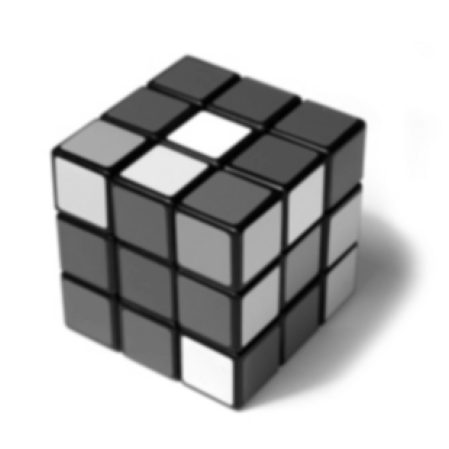

3. Canny:		 157.3307 ms


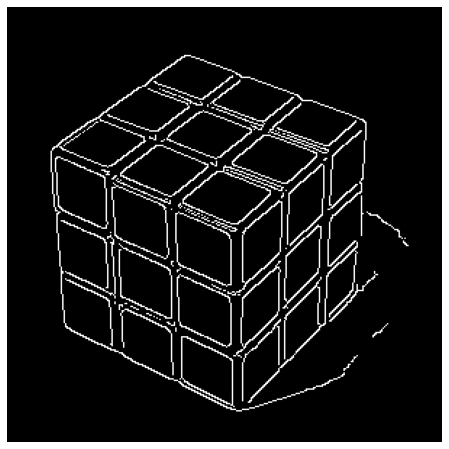

4. HoughLinesP:		 155.072 ms
5. Calc Angles:		 0.9392 ms


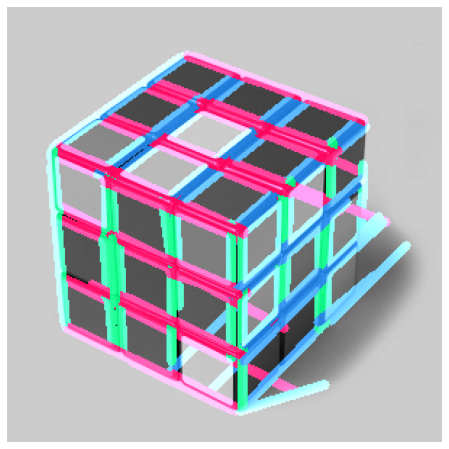

6. Lines to Points:	 164.8259 ms


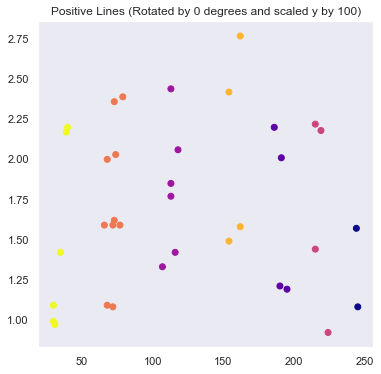

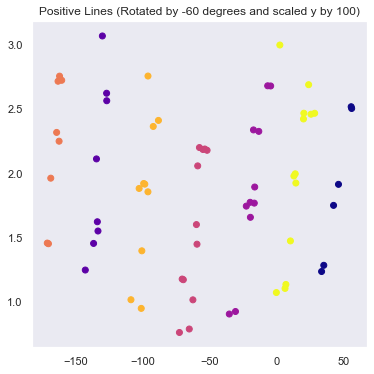

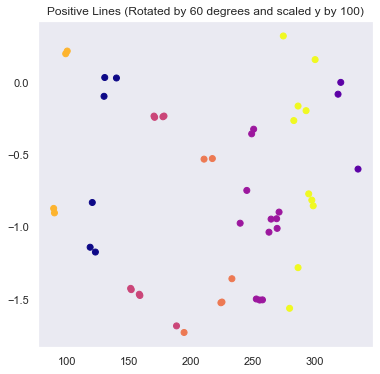

7. Clustering:		 630.1937 ms
8. Line Fitting:	 10.502 ms


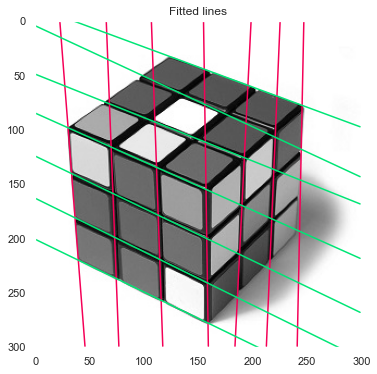

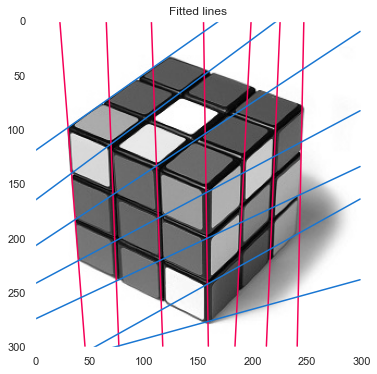

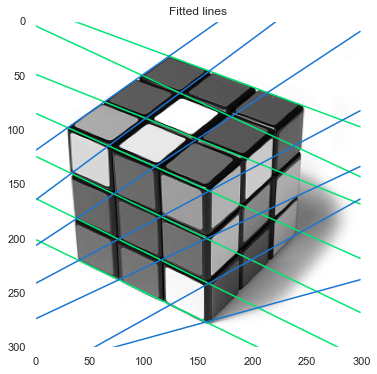

9. Plot Lines:		 670.7228 ms


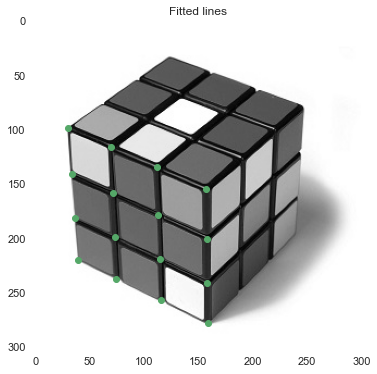

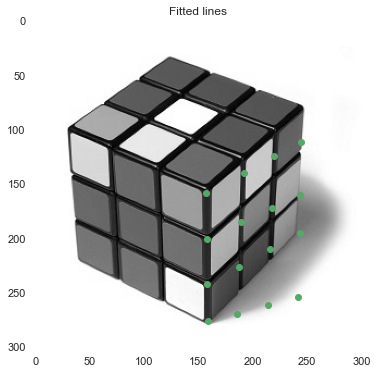

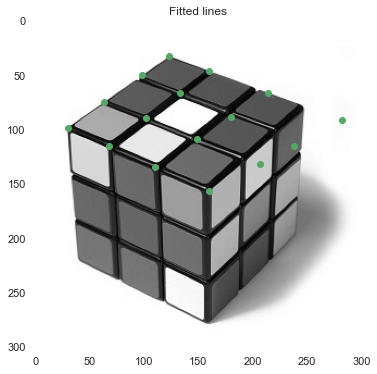

10. Find Intersections:	 1180.5917 ms
11. Extract Face Centers: 68.3489 ms


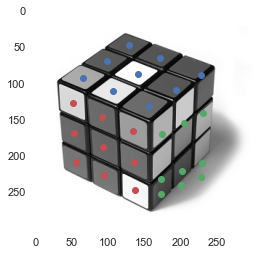

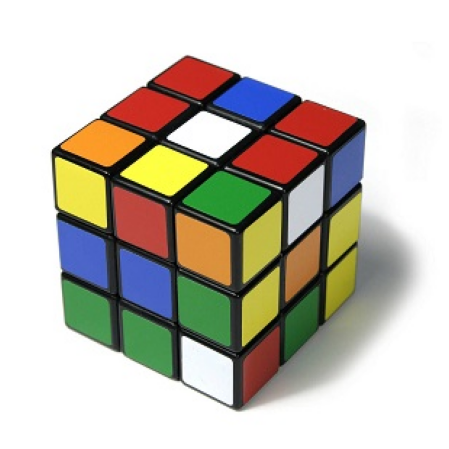

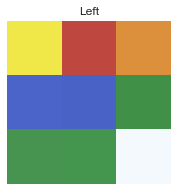

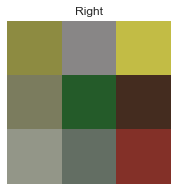

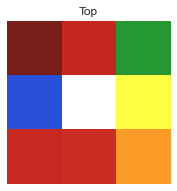

12. Extract Face Colors: 859.5464 ms
CPU times: total: 3.91 s
Wall time: 3.91 s


In [44]:
%%time
fitted_ms_all, fitted_bs_all, scalers_all, points_left, points_right, points_top, reconstructed_faces = extract_faces(
    img_1, 
    kernel_size=5,
    canny_low=0,
    canny_high=75,
    min_line_length=40,
    max_line_gap=20,
    rotate_degrees=[0, -60, 60],
    colors=colors,
    colors_01=colors_01,
    n_clusters=7,
    debug=True,
    debug_time=True)

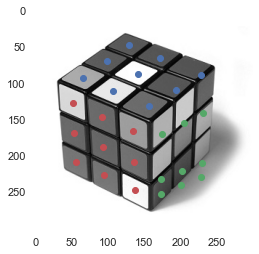

In [45]:
points_left = np.array(points_left)
points_right = np.array(points_right)
points_top = np.array(points_top)

face_indices = [
    [2,3,7,6],[6,7,11,10],[10,11,15,14],
    [1,2,6,5],[5,6,10,9],[9,10,14,13],
    [0,1,5,4],[4,5,9,8],[8,9,13,12]
    ]

face_centers = [[],[],[]]
plt.imshow(img_1_gray_rgb)
for face in face_indices:
    face_center = (points_left[face[0]] + points_left[face[1]] + points_left[face[2]] + points_left[face[3]]) / 4
    face_centers[0].append(face_center)
    plt.scatter([face_center[0]],[face_center[1]], c='r')

for face in face_indices:
    face_center = (points_right[face[0]] + points_right[face[1]] + points_right[face[2]] + points_right[face[3]]) / 4
    face_centers[1].append(face_center)
    plt.scatter([face_center[0]],[face_center[1]], c='g')

for face in face_indices:
    face_center = (points_top[face[0]] + points_top[face[1]] + points_top[face[2]] + points_top[face[3]]) / 4
    face_centers[2].append(face_center)
    plt.scatter([face_center[0]],[face_center[1]], c='b')

## Sample color from each center

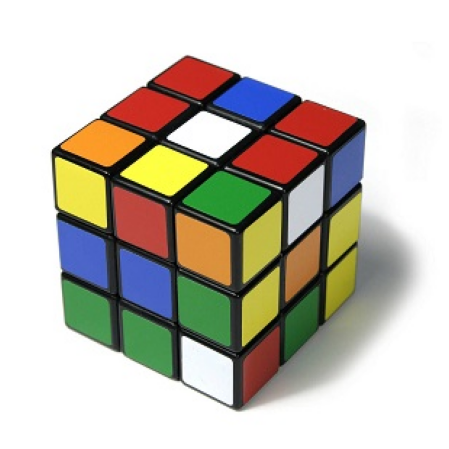

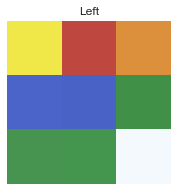

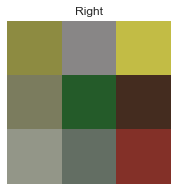

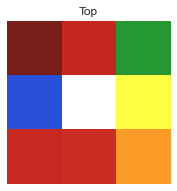

In [46]:
reconstructed_faces = []
faces_names = ["Left", "Right", "Top"]
disp(img_1)
for f in range(3):
    reconstructed_face = np.zeros((3,3,3), dtype=np.uint8)
    for i in range(9):
            x,y = face_centers[f][i]
            x,y = int(x), int(y)
            w = 10
            mean_color = img_1[y-w//2:y+w//2, x-w//2:x+w//2].mean(axis=(0,1)).astype(np.uint8)
            reconstructed_face[i//3,i%3,:] = mean_color
    disp(reconstructed_face, s=3, title=faces_names[f])
    
    reconstructed_faces.append(reconstructed_face)


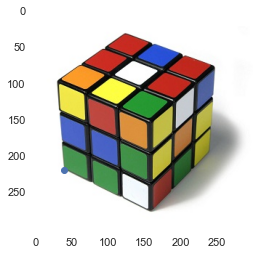

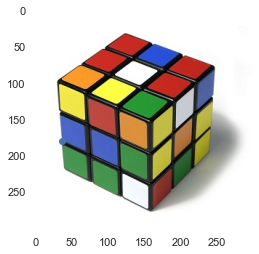

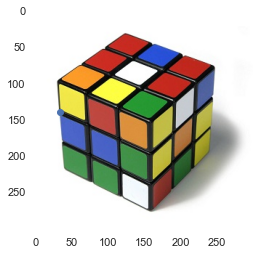

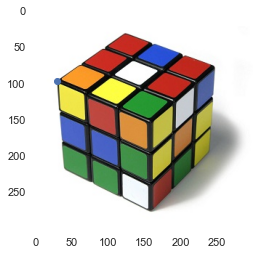

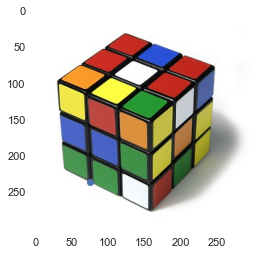

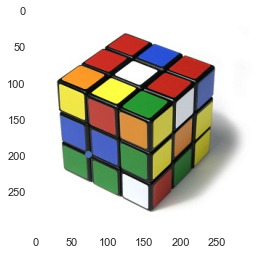

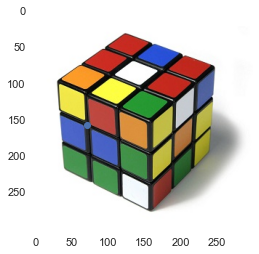

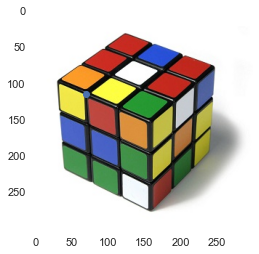

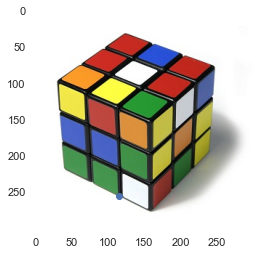

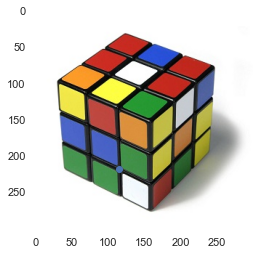

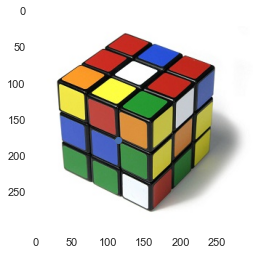

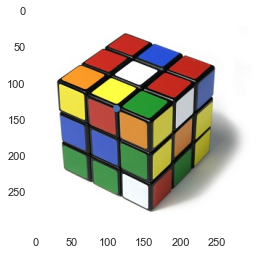

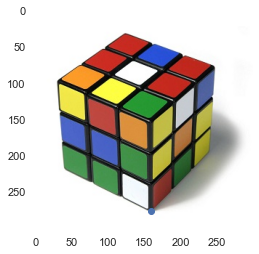

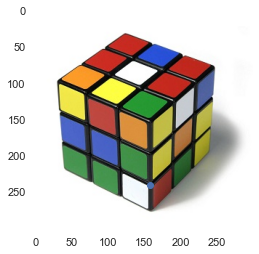

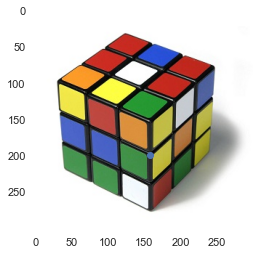

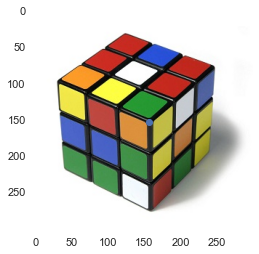

In [47]:
points_left
for i in range(len(points_left)):
    plt.imshow(img_1)
    plt.scatter([points_left[i][0]], [points_left[i][1]])
    plt.show()

4.1834655115708586
4.1834655115708586
4.1834655115708586
4.1834655115708586
4.1834655115708586
4.1834655115708586
4.1834655115708586


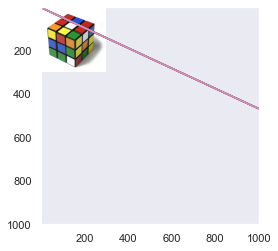

124.06996925420839
124.06996925420839
124.06996925420839
124.06996925420839
124.06996925420839
124.06996925420839
124.06996925420839


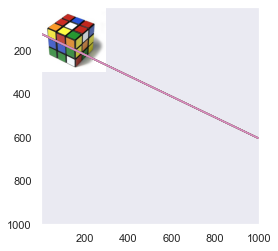

200.5875634038114
200.5875634038114
200.5875634038114
200.5875634038114
200.5875634038114
200.5875634038114
200.5875634038114


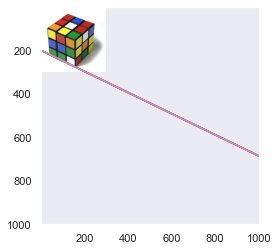

84.52639287866545
84.52639287866545
84.52639287866545
84.52639287866545
84.52639287866545
84.52639287866545
84.52639287866545


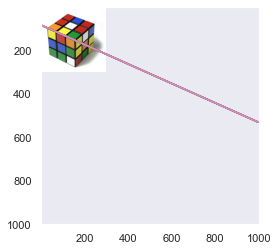

48.709384099306945
48.709384099306945
48.709384099306945
48.709384099306945
48.709384099306945
48.709384099306945
48.709384099306945


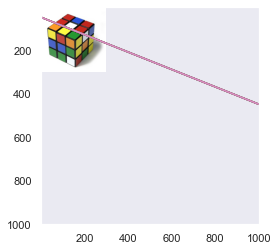

162.85387271431244
162.85387271431244
162.85387271431244
162.85387271431244
162.85387271431244
162.85387271431244
162.85387271431244


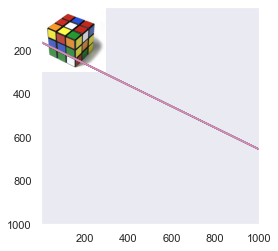

-13.219039203832018
-13.219039203832018
-13.219039203832018
-13.219039203832018
-13.219039203832018
-13.219039203832018
-13.219039203832018


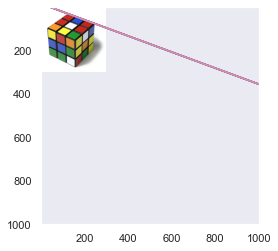

In [48]:
plt.imshow(img_1)
for i in range(7):
    plt.imshow(img_1)
    for j in range(7):
        m1 = fitted_ms_all[0][j]
        b1 = fitted_bs_all[0][j]
        b1 = -b1/m1
        m1 = 1/m1
        m2 = fitted_ms_all[1][i]
        b2 = fitted_bs_all[1][i]
        print(b2)

        # xx = np.arange(1,1000,1)
        # yy = m1*xx+b1
        # plt.plot(xx, yy)

        xx = np.arange(1,1000,1)
        yy = m2*xx+b2
        plt.plot(xx, yy)

        # x = (b2-b1)/(m1-m2) 
        # y = m1*x+b1
        # plt.scatter([x],[y])

    plt.xlim([1,1000])
    plt.ylim([1,1000])
    plt.gca().invert_yaxis()
    plt.show()

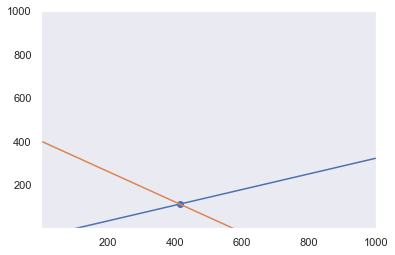

In [49]:
m1 = 0.36
m2 = -0.699
b1 = -37
b2 = 401.94

xx = np.arange(1,1000,1)
yy = m1*xx+b1
plt.plot(xx, yy)

xx = np.arange(1,1000,1)
yy = m2*xx+b2
plt.plot(xx, yy)

x = (b2-b1)/(m1-m2) 
y = m1*x+b1
plt.scatter([x],[y])

plt.xlim(1,1000)
plt.ylim(1,1000)
plt.show()

In [50]:
a = np.array([[1,2],[3,4],[5,9]])
scl = StandardScaler()
scl.fit(a)
scl.transform(a)

array([[-1.22474487, -1.01904933],
       [ 0.        , -0.33968311],
       [ 1.22474487,  1.35873244]])

In [51]:
-1.22474487/-1.01904933

1.2018504246501982

In [52]:
scl.inverse_transform(np.repeat(np.array([1/2])[:,None], 2, 1))

array([[3.81649658, 6.47196014]])